In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
pip install opencv-python

     ---------------------------------------- 38.2/38.2 MB 9.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Import Necessary Modules & Packages

In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime
from collections import deque
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Set The Hyperparameter

In [ ]:
# hyperparameter
height = 256
width = 256
channels = 3
batch_size = 32
img_shape = (height, width, channels)
img_size = (height, width)

# Create, Split, and Check the Dataset

In [ ]:
os.getcwd()

'C:\\Users\\shehjar\\OneDrive\\Desktop\\CIS515\\Project'

In [ ]:
DATA_DIR = os.path.join(os.getcwd(),"Input","WorkoutDataset")

In [ ]:
DATA_DIR

'C:\\Users\\shehjar\\OneDrive\\Desktop\\CIS515\\Project\\Input\\WorkoutDataset'

In [ ]:
# DATA_DIR = r'/gdrive/My Drive/CIS515/Workout_DataSet'

## Create Train and Validation Dataset

In [ ]:


train_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                       labels = 'inferred',
                                                       label_mode = 'categorical',
                                                       validation_split = 0.1,
                                                       subset = 'training',
                                                       image_size = img_size,
                                                       shuffle = True,
                                                       batch_size = batch_size,
                                                       seed = 127
                                                      )

val_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                     labels = 'inferred',
                                                     label_mode = 'categorical',
                                                     validation_split = 0.1,
                                                     subset = 'validation',
                                                     image_size = img_size,
                                                     shuffle = True,
                                                     batch_size = batch_size,
                                                     seed = 127
                                                    )

labels = train_ds.class_names
print(labels)

with open('workout_label.txt', 'w') as f:
    for workout_class in labels:
        f.write(f'{workout_class}\n')

Found 13853 files belonging to 22 classes.
Using 12468 files for training.
Found 13853 files belonging to 22 classes.
Using 1385 files for validation.
['barbell biceps curl', 'bench press', 'chest fly machine', 'deadlift', 'decline bench press', 'hammer curl', 'hip thrust', 'incline bench press', 'lat pulldown', 'lateral raises', 'leg extension', 'leg raises', 'plank', 'pull up', 'push up', 'romanian deadlift', 'russian twist', 'shoulder press', 'squat', 't bar row', 'tricep dips', 'tricep pushdown']


## Augment & Check Train Dataset

In [ ]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.GaussianNoise(10),
                                         tf.keras.layers.RandomContrast(0.1),
                                         tf.keras.layers.RandomZoom(0.2)
                                        ])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

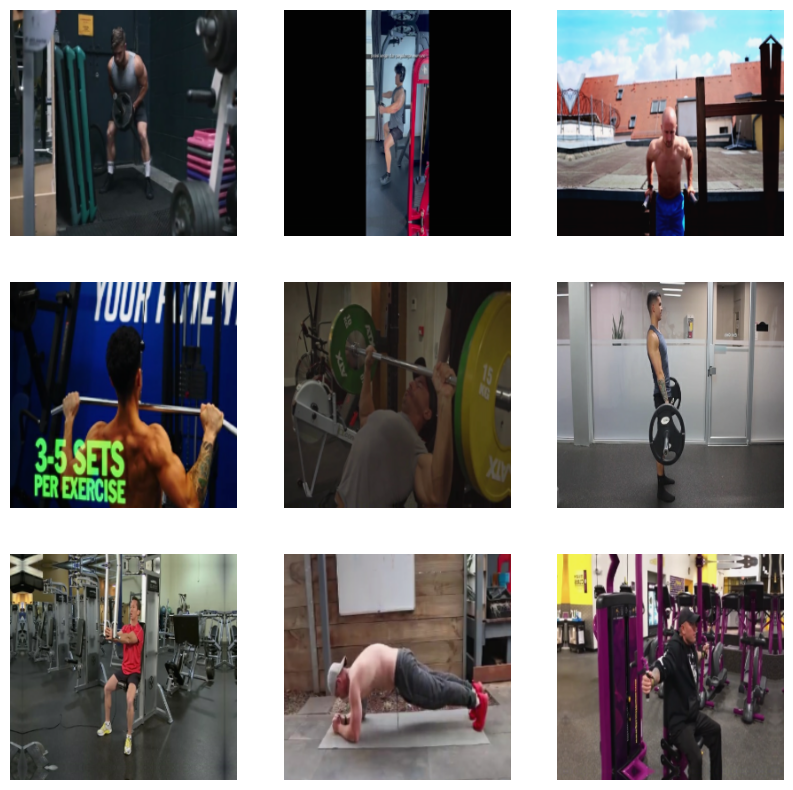

In [ ]:
#Defing a function to see images
def show_img(data):
    plt.figure(figsize=(10,10))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

#Plotting the images in dataset
show_img(train_ds)

# Create, Compile, Train, and Evaluate The Model

In [ ]:
# load pre-trained InceptionV3
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')

for layer in pre_trained.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 7s 0us/step


In [ ]:
x = pre_trained.output
# x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dense(256, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
predictions = tf.keras.layers.Dense(len(labels), activation='softmax')(x)

workout_model = tf.keras.models.Model(inputs = pre_trained.input,
                                      outputs = predictions
                                     )

workout_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy']
                     )

workout_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_5 (BatchNo  (None, 29, 29, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 29, 29, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 29, 29, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 29, 29, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 29, 29, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 29, 29, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 29, 29, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 29, 29, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 14, 14, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 14, 14, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 14, 14, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 14, 14, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 14, 14, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 14, 14, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 14, 14, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 14, 14, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 14, 14, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 14, 14, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 14, 14, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 14, 14, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 14, 14, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 14, 14, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 14, 14, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 14, 14, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 14, 14, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 14, 14, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 14, 14, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 6, 6, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 6, 6, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 6, 6, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

## Train Model

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss',
                                        patience = 5,
                                        mode = 'auto',
                                        restore_best_weights = True
                                       )

history = workout_model.fit(train_ds,
                            validation_data = val_ds,
                            epochs = 50
#                             callbacks = [early_stopping_callback]
                           )

Epoch 1/50
170/390 [============>.................] - ETA: 7:10 - loss: 15.5333 - accuracy: 0.0627

KeyboardInterrupt: 

## Evaluate Model

In [ ]:
evaluate = workout_model.evaluate(val_ds)

epoch = range(len(history.history["loss"]))
plt.figure()
plt.plot(epoch, history.history['loss'], 'red', label = 'train_loss')
plt.plot(epoch, history.history['val_loss'], 'blue', label = 'val_loss')
plt.plot(epoch, history.history['accuracy'], 'orange', label = 'train_acc')
plt.plot(epoch, history.history['val_accuracy'], 'green', label = 'val_acc')
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

## Save Model History to csv

In [ ]:
hist_df = pd.DataFrame(history.history)

hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Save and Test The Model to Predict Video

In [ ]:
current_datetime = datetime.now()

# Save Model
workout_model.save(f'workout_model_{current_datetime}')

# Save .h5 model
workout_model.save(f'workout_model_{current_datetime}.h5')

# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_saved_model(f'./workout_model_{current_datetime}')
tflite_model = converter.convert()

# Save the tflite model
with open(f'workout_model{current_datetime}.tflite', 'wb') as f:
    f.write(tflite_model)